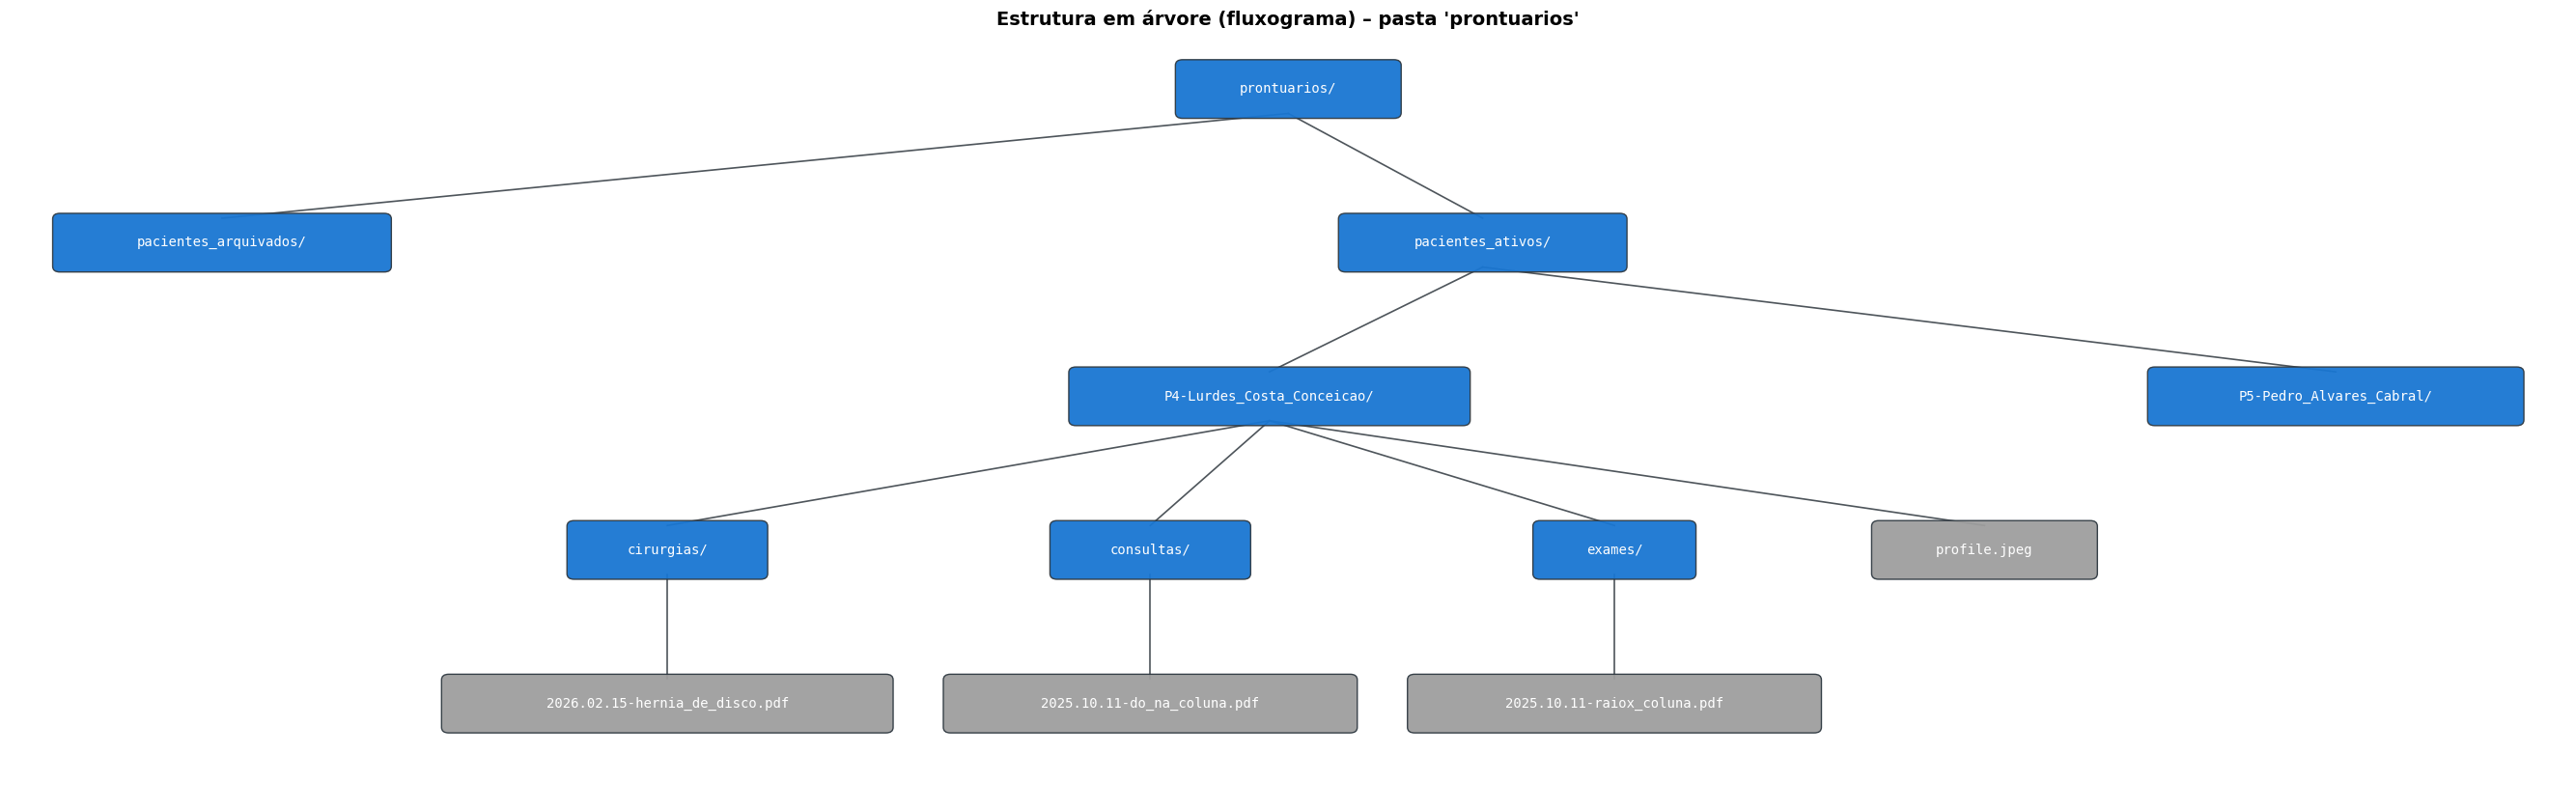

In [14]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# ---- Helpers to build and layout the tree (width-aware, no overlap) ----
def build_fs_tree(root):
    name = os.path.basename(os.path.normpath(root)) or root
    node = {"name": name, "is_dir": True, "children": []}
    try:
        entries = sorted(os.listdir(root))
    except FileNotFoundError:
        raise FileNotFoundError(f"Caminho não encontrado: {root}")
    for item in entries:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            node["children"].append(build_fs_tree(path))
        else:
            node["children"].append({"name": item, "is_dir": False, "children": []})
    return node

def annotate_sizes(node, char_w=0.14, base_w=0.8, min_w=1.3, box_h=0.8, sep=0.6):
    """Annotate each node with box_w/box_h and subtree_w using children widths."""
    label = node["name"] + ("/" if node.get("is_dir", False) else "")
    node["label"] = label
    node["box_w"] = max(min_w, base_w + char_w * len(label))
    node["box_h"] = box_h
    for c in node.get("children", []):
        annotate_sizes(c, char_w, base_w, min_w, box_h, sep)
    if node.get("children"):
        total_children = sum(c["subtree_w"] for c in node["children"]) + sep * (len(node["children"]) - 1)
        node["subtree_w"] = max(node["box_w"], total_children)
    else:
        node["subtree_w"] = node["box_w"]
    return node

def assign_positions(node, x_left=0.0, level=0, y_spacing=2.2, sep=0.6):
    """Assign x,y positions so sibling subtrees are spaced by subtree width (no overlap)."""
    node["y"] = -level * y_spacing
    if not node.get("children"):
        node["x"] = x_left + node["box_w"] / 2.0
        return node["x"]
    cursor = x_left
    for i, c in enumerate(node["children"]):
        assign_positions(c, cursor, level + 1, y_spacing, sep)
        cursor += c["subtree_w"] + (sep if i < len(node["children"]) - 1 else 0.0)
    span_left = x_left
    span_right = x_left + sum(c["subtree_w"] for c in node["children"]) + sep * (len(node["children"]) - 1)
    node["x"] = (span_left + span_right) / 2.0
    return node["x"]

def count_depth(node):
    if not node.get("children"):
        return 1
    return 1 + max(count_depth(c) for c in node["children"])

def find_upwards(start_dir, name):
    p = os.path.abspath(start_dir)
    while True:
        candidate = os.path.join(p, name)
        if os.path.exists(candidate):
            return candidate
        parent = os.path.dirname(p)
        if parent == p:
            return None
        p = parent

def resolve_root(root_name):
    # 1. If path exists directly (relative or absolute)
    if os.path.exists(root_name):
        return os.path.abspath(root_name)
    # 2. Try inside a data/ folder upward
    data_base = find_upwards(os.getcwd(), 'data')
    if data_base:
        candidate = os.path.join(data_base, root_name)
        if os.path.exists(candidate):
            return candidate
    # 3. Try upward search for folder name itself
    return find_upwards(os.getcwd(), root_name)

def draw_tree_auto(root_name):
    base = resolve_root(root_name)
    if base is None:
        print(f"Pasta '{root_name}' não encontrada a partir de {os.getcwd()}.")
        return
    tree = build_fs_tree(base)
    tree = annotate_sizes(tree)
    assign_positions(tree)
    depth = count_depth(tree)
    fig_w = max(10, tree["subtree_w"] * 0.9 + 2)
    fig_h = max(4, depth * 1.7)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Edges
    stack = [tree]
    while stack:
        n = stack.pop()
        for c in n.get("children", []):
            ax.plot([n["x"], c["x"]], [n["y"] - 0.35, c["y"] + 0.35], color="#4e555b", linewidth=1.2, zorder=1)
            stack.append(c)

    # Nodes (boxes)
    stack = [tree]
    while stack:
        n = stack.pop()
        x, y = n["x"], n["y"]
        w, h = n["box_w"], n["box_h"]
        face = "#1976d2" if n.get("is_dir", False) else "#9e9e9e"
        box = FancyBboxPatch((x - w/2, y - h/2), w, h,
                             boxstyle="round,pad=0.02,rounding_size=0.08",
                             linewidth=1.0, edgecolor="#2f3941", facecolor=face,
                             alpha=0.95, zorder=2)
        ax.add_patch(box)
        ax.text(x, y, n["label"], color="white", ha="center", va="center",
                fontsize=10, family="monospace", zorder=3)
        stack.extend(n.get("children", []))

    ax.set_xlim(-0.5, tree["subtree_w"] + 0.5)
    ax.set_ylim(-depth * 2.2 + 0.8, 0.8)
    ax.set_title(f"Estrutura em árvore (fluxograma) – pasta '{os.path.basename(base)}'", fontsize=14, weight="bold")
    ax.axis("off")
    ax.margins(x=0.02, y=0.02)
    plt.tight_layout()
    plt.show()

# ---- Run ----
draw_tree_auto("prontuarios")